In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import pathlib

In [3]:
import sklearn

M, m, p = sklearn.__version__.split('.')
display(sklearn.__version__)
assert int(M) == 1
assert int(m) >= 2

'1.2.2'

# Load Data

In [4]:
data_folders = [
    pathlib.Path(f'./data/bicing/truncated/{y}') for y in [2022]
]

In [5]:
pandas_kwargs = {
    'index_col': 0,
}
df = pd.concat([pd.read_csv(file, **pandas_kwargs) for data_folder in data_folders for file in
                data_folder.glob('*/*.csv')]).drop_duplicates()

In [6]:
df = df.assign(
    datetime=lambda x: pd.to_datetime(x.datetime),
    percentage_docks_available=df.num_docks_available / (df.num_docks_available + df.num_bikes_available),
).drop(columns=['num_docks_available', 'num_bikes_available']).sort_values(['station_id', 'datetime'])

In [7]:
assert (df.percentage_docks_available > 1).sum() == 0

### Add station info

In [8]:
station_info = pd.read_csv('./data/bicing_info.csv')
df = pd.merge(left=df, right=station_info[['station_id', 'lat', 'lon', 'altitude', 'post_code']],
              on=['station_id'])
df.head()

,station_id,datetime,year,month,day,hour,percentage_docks_available,lat,lon,altitude,post_code
0,1,2022-01-01 00:00:00,2022,1,1,0,0.608696,41.397978,2.180107,16,8013
1,1,2022-01-01 00:00:00,2022,1,1,0,0.625000,41.397978,2.180107,16,8013
2,1,2022-01-01 01:00:00,2022,1,1,1,0.681818,41.397978,2.180107,16,8013
3,1,2022-01-01 02:00:00,2022,1,1,2,0.722826,41.397978,2.180107,16,8013
4,1,2022-01-01 03:00:00,2022,1,1,3,0.737458,41.397978,2.180107,16,8013


### climate

In [9]:
df_climate_ = pd.read_csv('./data/clima.csv', parse_dates=['time'])

df_climate = df_climate_.assign(
    year=df_climate_.time.dt.year,
    month=df_climate_.time.dt.month,
    day=df_climate_.time.dt.day,
    hour=df_climate_.time.dt.hour
)
df = pd.merge(left=df, right=df_climate.drop(columns=['time']), on=['hour', 'day', 'month', 'year'])

In [10]:
df

,station_id,datetime,year,month,day,hour,percentage_docks_available,lat,lon,altitude,post_code,temperature_2m,total_cloud_cover,total_precipitation,windspeed_10m
0,1,2022-01-01 00:00:00,2022,1,1,0,0.608696,41.397978,2.180107,16,8013,282.597015,0.339310,4.111789e-07,2.181416
1,1,2022-01-01 00:00:00,2022,1,1,0,0.625000,41.397978,2.180107,16,8013,282.597015,0.339310,4.111789e-07,2.181416
2,2,2022-01-01 00:00:00,2022,1,1,0,0.356322,41.395488,2.177198,17,8013,282.597015,0.339310,4.111789e-07,2.181416
3,2,2022-01-01 00:00:00,2022,1,1,0,0.364943,41.395488,2.177198,17,8013,282.597015,0.339310,4.111789e-07,2.181416
4,3,2022-01-01 00:00:00,2022,1,1,0,0.555556,41.394156,2.181331,11,8013,282.597015,0.339310,4.111789e-07,2.181416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419981,515,2022-01-13 11:00:00,2022,1,13,11,0.971429,41.435207,2.194800,19,8030,282.674469,0.007935,0.000000e+00,2.058891
4419982,516,2022-01-13 11:00:00,2022,1,13,11,0.250000,41.435460,2.200157,15,8030,282.674469,0.007935,0.000000e+00,2.058891
4419983,517,2022-01-13 11:00:00,2022,1,13,11,0.300000,41.462095,2.178959,44,8033,282.674469,0.007935,0.000000e+00,2.058891
4419984,518,2022-01-13 11:00:00,2022,1,13,11,1.000000,41.424689,2.157049,112,8032,282.674469,0.007935,0.000000e+00,2.058891


In [11]:
import numpy as np

# merge with previous hours
df = df.sort_values(['station_id', 'datetime']).assign(
    day_of_week=lambda x: x.datetime.dt.day_of_week,
    is_weekend=lambda x: x.day_of_week >= 5,
    is_night=lambda x: np.bitwise_or(x.hour >= 20, x.hour <= 7),
    is_work_morning=lambda x: np.bitwise_and(x.hour >= 6, x.hour <= 10) & np.bitwise_not(x.is_weekend),
    is_summer=lambda x: x.month.between(6, 8),
    ctx_1=lambda x: x.percentage_docks_available.shift(1),
    ctx_2=lambda x: x.percentage_docks_available.shift(2),
    ctx_3=lambda x: x.percentage_docks_available.shift(3),
    ctx_4=lambda x: x.percentage_docks_available.shift(4),
    station_id_aux=lambda x: x.station_id.shift(4),
    altitude=lambda x: x.altitude.astype(int)
)

In [12]:
df = df \
    .query('not ctx_1.isnull()') \
    .query('not ctx_2.isnull()') \
    .query('not ctx_3.isnull()') \
    .query('not ctx_4.isnull()') \
    .query('station_id == station_id_aux') \
    .drop(columns=['station_id_aux']) \
    .query('not percentage_docks_available.isnull()')


In [13]:
dfnans = df.isna().sum()
assert dfnans[dfnans > 0].empty

In [14]:
df.head()

,station_id,datetime,year,month,day,hour,percentage_docks_available,lat,lon,altitude,...,windspeed_10m,day_of_week,is_weekend,is_night,is_work_morning,is_summer,ctx_1,ctx_2,ctx_3,ctx_4
2020,1,2022-01-01 03:00:00,2022,1,1,3,0.737458,41.397978,2.180107,16,...,2.155734,5,True,True,False,False,0.722826,0.681818,0.625000,0.608696
2525,1,2022-01-01 04:00:00,2022,1,1,4,0.717391,41.397978,2.180107,16,...,2.059913,5,True,True,False,False,0.737458,0.722826,0.681818,0.625000
3030,1,2022-01-01 05:00:00,2022,1,1,5,0.717391,41.397978,2.180107,16,...,1.985322,5,True,True,False,False,0.717391,0.737458,0.722826,0.681818
3535,1,2022-01-01 06:00:00,2022,1,1,6,0.672101,41.397978,2.180107,16,...,1.993759,5,True,True,False,False,0.717391,0.717391,0.737458,0.722826
4040,1,2022-01-01 07:00:00,2022,1,1,7,0.639706,41.397978,2.180107,16,...,2.046561,5,True,True,False,False,0.672101,0.717391,0.717391,0.737458


# CV

In [15]:
from sklearn import model_selection, linear_model, ensemble, neighbors, preprocessing, metrics, pipeline, compose

In [16]:
# CrossValidation

scoring = 'neg_root_mean_squared_error'


def get_cv_scores(model, X: pd.DataFrame, y: pd.Series, cv=4, verbose=0):
    if verbose > 0: display(f'{X.shape=}')
    if verbose > 0: display(f'{y.shape=}')

    return model_selection.cross_val_score(
        model, X, y,
        scoring=scoring,
        cv=model_selection.TimeSeriesSplit(cv),
        verbose=verbose,
    )

In [17]:
# Custom Regressor
from dataclasses import dataclass
from sklearn import linear_model
from typing import List, Dict


# create model per
@dataclass
class BicingRegression:
    grouping_column_name: str

    regressor_class: type = None
    clip: bool = True
    verbose: int = 0

    groups_: List[int] = None
    regressors_: Dict[int, object] = None
    generic_regressor_: object = None

    def __post_init__(self):
        self.regressors_ = self.regressors_ or {}
        self.regressor_class = self.regressor_class or linear_model.LinearRegression

    def fit(self, X, y, weights=None):
        assert y.isna().sum() == 0
        if self.verbose >= 10:
            print(f'{type(X)=}')
            print(f'{type(y)=}')
        self.groups_ = X.loc[:, self.grouping_column_name].unique()

        for ii, group in enumerate(self.groups_):
            if self.verbose > 0:
                print(f'Training regressor {ii + 1}/{len(self.groups_)}')
            self.regressors_[group] = self.regressor_class()

            X_ = X.query(f'{self.grouping_column_name} == {group}').drop(columns=[self.grouping_column_name])
            y_ = y.loc[X_.index]
            self.regressors_[group].fit(X_, y_)

        if self.verbose > 0:
            print(f'Training generic regressor')
        self.generic_regressor_ = self.regressor_class()
        self.generic_regressor_.fit(X.drop(columns=[self.grouping_column_name]), y)

        return self

    def predict(self, X):
        results = pd.DataFrame(
            index=X.index,
            columns=['prediction']
        )

        for group in self.groups_:
            X_ = X.query(f'{self.grouping_column_name} == {group}').drop(columns=[self.grouping_column_name])
            if len(X_) == 0:
                continue
            y_pred = self.regressors_[group].predict(X_)
            results.loc[X_.index, 'prediction'] = y_pred

        for unseen_group in X[self.grouping_column_name].unique():
            if unseen_group not in self.groups_:
                X_ = X.query(f'{self.grouping_column_name} == {unseen_group}').drop(columns=[self.grouping_column_name])
                if len(X_) == 0:
                    continue
                y_pred = self.generic_regressor_.predict(X_)
                results.loc[X_.index, 'prediction'] = y_pred

        if self.clip:
            return results.assign(prediction=lambda x: np.clip(x.prediction, 0, 1))['prediction']
        else:
            return results['prediction']

    @property
    def coef_(self):
        coefs = []
        for regressor in self.regressors_.values():
            coefs.append(regressor.coef_)
        coefs = np.array(coefs)
        print(coefs.shape)

        return np.mean(coefs, axis=0)

In [18]:
df.columns

Index(['station_id', 'datetime', 'year', 'month', 'day', 'hour',
       'percentage_docks_available', 'lat', 'lon', 'altitude', 'post_code',
       'temperature_2m', 'total_cloud_cover', 'total_precipitation',
       'windspeed_10m', 'day_of_week', 'is_weekend', 'is_night',
       'is_work_morning', 'is_summer', 'ctx_1', 'ctx_2', 'ctx_3', 'ctx_4'],
      dtype='object')

In [19]:
# pipes = [
#     {
#         'model': pipeline.Pipeline(
#             [
#                 ("transformer", compose.ColumnTransformer(
#                     [
#                         ('previous_hours', preprocessing.MinMaxScaler((0, 1)), [f"ctx_{ii + 1}" for ii in range(2)]),
#                         ('std', preprocessing.MinMaxScaler((0, 1)), ["hour"]),
#                     ],
#                     remainder="drop", )
#                  ),
#                 ("regressor", ensemble.RandomForestRegressor(verbose=3, n_jobs=-1))
#             ]
#         ),
#         'weights': None,
#     },
#     {
#         'model': pipeline.Pipeline(
#             [
#                 ("transformer", compose.ColumnTransformer(
#                     [
#                         ('previous_hours', preprocessing.MinMaxScaler((0, 1)), [f"ctx_{ii + 1}" for ii in range(4)]),
#                         ('12bins', preprocessing.KBinsDiscretizer(encode="ordinal", n_bins=12, subsample=None),
#                          ["hour"]),
#                         ('4bins', preprocessing.KBinsDiscretizer(encode="ordinal", n_bins=4, subsample=None),
#                          ["altitude", "temperature_2m"]),
#                     ],
#                     remainder="drop", )
#                  ),
#                 ("regressor", ensemble.RandomForestRegressor(verbose=1, n_jobs=-1))
#             ]
#         ),
#         'weights': None,
#     },
#     {
#         'model': pipeline.Pipeline(
#             [
#                 ("transformer", compose.ColumnTransformer(
#                     [
#                         ('previous_hours', preprocessing.MinMaxScaler((0, 1)), [f"ctx_{ii + 1}" for ii in range(4)]),
#                         ('std', preprocessing.StandardScaler(), ["temperature_2m"]),
#                     ],
#                     remainder="drop", )
#                  ),
#                 ("regressor", linear_model.LinearRegression())
#             ]
#         ),
#         'weights': None,
#     },
#     {
#         'model': pipeline.Pipeline(
#             [
#                 ("transformer", compose.ColumnTransformer(
#                     [
#                         ('previous_hours', preprocessing.MinMaxScaler((0, 1)), [f"ctx_{ii + 1}" for ii in range(4)]),
#                         ('std', preprocessing.StandardScaler(), ["temperature_2m", "altitude"]),
#                     ],
#                     remainder="drop", )
#                  ),
#                 ("regressor", linear_model.LinearRegression())
#             ]
#         ),
#         'weights': None,
#     },
#     {
#         'model': pipeline.Pipeline(
#             [
#                 ("transformer", compose.ColumnTransformer(
#                     [
#                         ('previous_hours', preprocessing.MinMaxScaler((0, 1)), [f"ctx_{ii + 1}" for ii in range(4)]),
#                         ('std', preprocessing.StandardScaler(), ["temperature_2m", "altitude"]),
#                         ('coord', preprocessing.StandardScaler(), ["lat", "lon"]),
#                         # ('cat', preprocessing.OneHotEncoder(handle_unknown="ignore"), ["post_code"]),
#                         ('clean', preprocessing.FunctionTransformer(feature_names_out='one-to-one'), ['station_id']),
#                     ],
#                     remainder="drop",
#                     sparse_threshold=0,
#                 ).set_output(transform='pandas')
#                  ),
#                 ("regressor", BicingRegression(
#                     grouping_column_name='clean__station_id',
#                     verbose=10
#                 ))
#             ]
#         ),
#         'weights': None,
#     },
#     {
#         'model': pipeline.Pipeline(
#             [
#                 ("transformer", compose.ColumnTransformer(
#                     [
#                         ('previous_hours', preprocessing.MinMaxScaler((0, 1)), [f"ctx_{ii + 1}" for ii in range(4)]),
#                         ('12bins', preprocessing.KBinsDiscretizer(encode="ordinal", n_bins=12, subsample=None),
#                          ["hour"]),
#                         ('4bins', preprocessing.KBinsDiscretizer(encode="ordinal", n_bins=4, subsample=None),
#                          ["altitude", "temperature_2m"]),
#                     ],
#                     remainder="drop", )
#                  ),
#                 ("regressor", ensemble.RandomForestRegressor(verbose=1, n_jobs=-1))
#             ]
#         ),
#         'weights': None,
#     },

# ]

Y_COLUMN = 'percentage_docks_available'
pipes = [
    {
        'name': 'baseline',
        'model': pipeline.Pipeline(
            [
                ("transformer", compose.ColumnTransformer(
                    [
                        ('previous_hours', preprocessing.FunctionTransformer(feature_names_out="one-to-one"),
                         [f"ctx_{ii + 1}" for ii in range(2)]),
                    ],
                    remainder="drop", )
                 ),
                ("regressor", linear_model.LinearRegression())
            ]
        )
    },
    {
        'name': 'improved linear regression (std features)',
        'model': pipeline.Pipeline(
            [
                ("transformer", compose.ColumnTransformer(
                    [
                        (
                            'previous_hours', preprocessing.FunctionTransformer(feature_names_out="one-to-one"),
                            [f"ctx_{ii + 1}" for ii in range(2)]
                        ),
                        (
                            'std', preprocessing.StandardScaler(), ["hour", "altitude", "temperature_2m"]
                        ),
                    ],
                    remainder="drop", )
                 ),
                ("regressor", linear_model.LinearRegression())
            ]
        )
    },
    {
        'name': 'linear regression (features are KBins)',
        'model': pipeline.Pipeline(
            [
                ("transformer", compose.ColumnTransformer(
                    [
                        ('previous_hours', preprocessing.FunctionTransformer(feature_names_out="one-to-one"),
                         [f"ctx_{ii + 1}" for ii in range(2)]),
                        ('12bins', preprocessing.KBinsDiscretizer(encode="ordinal", n_bins=12, subsample=None),
                         ["hour"]),
                        ('4bins', preprocessing.KBinsDiscretizer(encode="ordinal", n_bins=4, subsample=None),
                         ["altitude", "temperature_2m"]),
                    ],
                    remainder="drop", )
                 ),
                ("regressor", linear_model.LinearRegression())
            ]
        )
    },
    {
        'name': 'random forest (std features)',
        'model': pipeline.Pipeline(
            [
                ("transformer", compose.ColumnTransformer(
                    [
                        (
                            'previous_hours', preprocessing.FunctionTransformer(feature_names_out="one-to-one"),
                            [f"ctx_{ii + 1}" for ii in range(2)]
                        ),
                        (
                            'std', preprocessing.StandardScaler(), ["hour", "altitude", "temperature_2m"]
                        ),
                    ],
                    remainder="drop", )
                 ),
                ("regressor",
                 ensemble.RandomForestRegressor(n_estimators=200, min_samples_leaf=0.05, verbose=3, n_jobs=-1))
            ]
        )
    },
    {
        'name': 'random forest (more features)',
        'model': pipeline.Pipeline(
            [
                ("transformer", compose.ColumnTransformer(
                    [
                        (
                            'previous_hours', preprocessing.FunctionTransformer(feature_names_out="one-to-one"),
                            [f"ctx_{ii + 1}" for ii in range(2)]
                        ),
                        (
                            '4bins', preprocessing.KBinsDiscretizer(encode="onehot", n_bins=4, subsample=None),
                            ["altitude", "temperature_2m"]
                        ),
                        (
                            '12bins', preprocessing.KBinsDiscretizer(encode="onehot", n_bins=12, subsample=None),
                            ["hour"]
                        ),
                    ],
                    remainder="drop", )
                 ),
                ("regressor",
                 ensemble.RandomForestRegressor(n_estimators=50, min_samples_leaf=0.05, verbose=3, n_jobs=-1))
            ]
        )
    },
    {
        'name': '1 regression per station (more features)',
        'model': pipeline.Pipeline(
            [
                ("transformer", compose.ColumnTransformer(
                    [
                        (
                            'previous_hours', preprocessing.FunctionTransformer(feature_names_out="one-to-one"),
                            [f"ctx_{ii + 1}" for ii in range(4)]
                        ),
                        (
                            'deltas', preprocessing.FunctionTransformer(
                                lambda x: x.ctx_1 - x.ctx_2,
                                feature_names_out=lambda t: ['1_2']),
                            [f"ctx_{ii + 1}" for ii in range(2)]
                        ),
                        (
                            '4bins', preprocessing.KBinsDiscretizer(encode="ordinal", n_bins=4, subsample=None),
                            ["temperature_2m"]
                        ),
                        (
                            'binary', preprocessing.Binarizer(threshold=0),
                            ["total_cloud_cover", "total_precipitation"]
                        ),
                        (
                            '12bins', preprocessing.KBinsDiscretizer(encode="ordinal", n_bins=12, subsample=None),
                            ["hour"]
                        ),
                        (
                            'clean', preprocessing.FunctionTransformer(feature_names_out="one-to-one"),
                            ["station_id"]
                        ),
                    ],
                    remainder="drop",
                    sparse_threshold=0
                ).set_output(transform='pandas')),
                ("regressor", BicingRegression(grouping_column_name='clean__station_id', verbose=3))
            ]
        )
    },
]

'Running model with IDX: 0 - 1 regression per station (more features)'

Pipeline(steps=[('transformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('previous_hours',
                                                  FunctionTransformer(feature_names_out='one-to-one'),
                                                  ['ctx_1', 'ctx_2', 'ctx_3',
                                                   'ctx_4']),
                                                 ('deltas',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x128612560>,
                                                                      func=<function <lambda> at 0x128612320>),
                                                  ['ctx_1', 'ctx_2']),
                                                 ('4bins',
                                                  KBinsDiscretizer(...
                                               18: LinearRegression(),
                                               19: LinearRegression(),
                                               20: LinearRegression(),
                                               21: LinearRegression(),
                                               22: LinearRegression(),
                                               23: LinearRegression(),
                                               24: LinearRegression(),
                                               25: LinearRegression(),
                                               26: LinearRegression(),
                                               27: LinearRegression(),
                                               28: LinearRegression(),
                                               29: LinearRegression(),
                                               30: LinearRegression(),
                                               31: LinearRegression(), ...},
                                  generic_regressor_=LinearRegression()))])

Training regressor 1/507
Training regressor 2/507
Training regressor 3/507
Training regressor 4/507
Training regressor 5/507
Training regressor 6/507
Training regressor 7/507
Training regressor 8/507
Training regressor 9/507
Training regressor 10/507
Training regressor 11/507
Training regressor 12/507
Training regressor 13/507
Training regressor 14/507
Training regressor 15/507
Training regressor 16/507
Training regressor 17/507
Training regressor 18/507
Training regressor 19/507
Training regressor 20/507
Training regressor 21/507
Training regressor 22/507
Training regressor 23/507
Training regressor 24/507
Training regressor 25/507
Training regressor 26/507
Training regressor 27/507
Training regressor 28/507
Training regressor 29/507
Training regressor 30/507
Training regressor 31/507
Training regressor 32/507
Training regressor 33/507
Training regressor 34/507
Training regressor 35/507
Training regressor 36/507
Training regressor 37/507
Training regressor 38/507
Training regressor 39

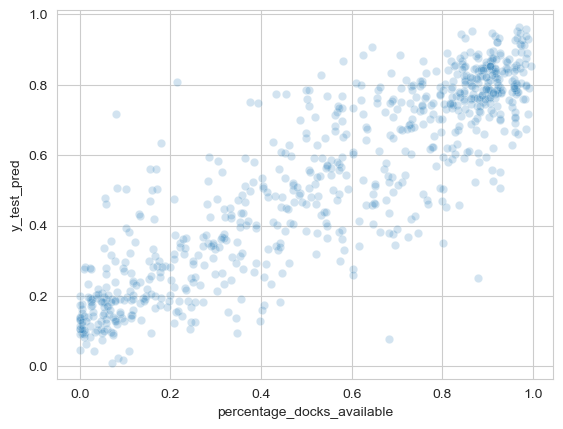

Training regressor 1/507
Training regressor 2/507
Training regressor 3/507
Training regressor 4/507
Training regressor 5/507
Training regressor 6/507
Training regressor 7/507
Training regressor 8/507
Training regressor 9/507
Training regressor 10/507
Training regressor 11/507
Training regressor 12/507
Training regressor 13/507
Training regressor 14/507
Training regressor 15/507
Training regressor 16/507
Training regressor 17/507
Training regressor 18/507
Training regressor 19/507
Training regressor 20/507
Training regressor 21/507
Training regressor 22/507
Training regressor 23/507
Training regressor 24/507
Training regressor 25/507
Training regressor 26/507
Training regressor 27/507
Training regressor 28/507
Training regressor 29/507
Training regressor 30/507
Training regressor 31/507
Training regressor 32/507
Training regressor 33/507
Training regressor 34/507
Training regressor 35/507
Training regressor 36/507
Training regressor 37/507
Training regressor 38/507
Training regressor 39

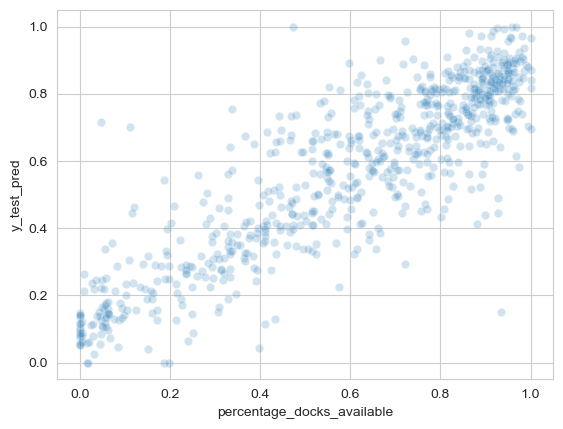

'--------------------------------------------------------------------------------'

In [23]:
df_ = df.query(f'month > 9').sort_values('datetime')
SHOW_CV_STEPS = True

for ii, dd in enumerate([pipes[-1]]):
    pipe = dd['model']
    display(f'Running model with IDX: {ii} - {dd["name"]}')
    display(pipe)

    if SHOW_CV_STEPS:
        cv = model_selection.TimeSeriesSplit(2)
        for jj, (train_idx, test_idx) in enumerate(cv.split(df_.drop(columns=[Y_COLUMN]))):
            df_train_ = df_.iloc[train_idx].reset_index()
            df_test_ = df_.iloc[test_idx].reset_index()

            pipe.fit(df_train_.drop(columns=[Y_COLUMN]), df_train_[Y_COLUMN])
            # display(
            #     pd.Series(
            #         data=pipe["regressor"].feature_importances_,
            #         index=list(filter(lambda x: not x.startswith('clean'), pipe["transformer"].get_feature_names_out()))
            #     )
            # )

            y_test_pred = pipe.predict(df_test_.drop(columns=[Y_COLUMN]))

            df_test_ = df_test_.assign(
                y_test_pred=y_test_pred
            )
            sns.scatterplot(
                data=df_test_.query('station_id == 20'),
                x=Y_COLUMN,
                y='y_test_pred',
                alpha=0.2
            )
            plt.show()

            #display(np.sqrt(metrics.mean_squared_error(y_true=df_test_[Y_COLUMN], y_pred=df_test_['y_test_pred'])))

    # cv_scores = get_cv_scores(pipe, df_.drop(columns=[Y_COLUMN]), df_[Y_COLUMN], cv=3, verbose=1)
    # display(f'{np.mean(cv_scores):0.4f}')

    display('-' * 80)


# final fit

In [25]:
# load X_val
X_val = pd.read_csv('./data/validation/X_validation.csv', index_col="index")
X_val = X_val.assign(index=X_val.index)

X_val = X_val.assign(year=2023)

X_val = pd.merge(
    left=X_val,
    right=station_info[['station_id', 'lat', 'lon', 'altitude', 'post_code']],
    on=['station_id'],

)
X_val = pd.merge(left=X_val, right=df_climate.drop(columns=['time']), on=['hour', 'day', 'month', 'year'])
X_val = X_val.assign(
    date=lambda x: pd.to_datetime(dict(year=x.year, month=x.month, day=x.day)),
    day_of_week=lambda x: x.date.dt.day_of_week,
    is_weekend=lambda x: x.day_of_week >= 5,
    is_night=lambda x: np.bitwise_or(x.hour >= 20, x.hour <= 7),
    is_work_morning=lambda x: np.bitwise_and(x.hour >= 6, x.hour <= 10) & np.bitwise_not(x.is_weekend),
    is_summer=lambda x: x.month.between(6, 8),
    altitude=lambda x: x.altitude.astype(int),
).rename(
    columns={
        'ctx-1': 'ctx_1',
        'ctx-2': 'ctx_2',
        'ctx-3': 'ctx_3',
        'ctx-4': 'ctx_4',
    }
)
X_val = X_val.set_index("index").sort_index()
X_val = X_val.assign(index=X_val.index)
X_val.head()

,station_id,month,day,hour,ctx_4,ctx_3,ctx_2,ctx_1,year,lat,...,total_cloud_cover,total_precipitation,windspeed_10m,date,day_of_week,is_weekend,is_night,is_work_morning,is_summer,index
index,,,,,,,,,,,,,,,,,,,,,
0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,2023,41.387306,...,0.134741,0.0,1.892034,2023-03-07,1,False,False,True,False,0
1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,2023,41.398624,...,0.288515,0.0,5.151473,2023-03-23,3,False,False,False,False,1
2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,2023,41.396839,...,1.000004,0.0,3.311623,2023-03-31,4,False,True,False,False,2
3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,2023,41.405007,...,0.138855,0.0,5.492265,2023-03-23,3,False,False,False,False,3
4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,2023,41.402988,...,0.019991,0.0,3.738923,2023-03-04,5,True,True,False,False,4


In [136]:
model_idx = len(pipes) - 1
model_name = pipes[model_idx]["name"]
pipe = pipes[model_idx]["model"]

display(model_name)
display(pipe)

df_ = df.copy()
pipe = pipe.fit(df_.drop(columns=[Y_COLUMN]), df_[Y_COLUMN])

'1 regression per station (more features)'

Pipeline(steps=[('transformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('previous_hours',
                                                  FunctionTransformer(feature_names_out='one-to-one'),
                                                  ['ctx_1', 'ctx_2', 'ctx_3',
                                                   'ctx_4']),
                                                 ('deltas',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x130f25e10>,
                                                                      func=<function <lambda> at 0x130a8d000>),
                                                  ['ctx_1', 'ctx_2']),
                                                 ('4bins',
                                                  KBinsDiscretizer(...
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=12,
                                                                   subsample=None),
                                                  ['hour']),
                                                 ('clean',
                                                  FunctionTransformer(feature_names_out='one-to-one'),
                                                  ['station_id'])])),
                ('regressor',
                 BicingRegression(grouping_column_name='clean__station_id',
                                  regressor_class=<class 'sklearn.linear_model._base.LinearRegression'>,
                                  clip=True,
                                  verbose=3,
                                  groups_=None,
                                  regressors_={},
                                  generic_regressor_=None))])

Training regressor 1/507
Training regressor 2/507
Training regressor 3/507
Training regressor 4/507
Training regressor 5/507
Training regressor 6/507
Training regressor 7/507
Training regressor 8/507
Training regressor 9/507
Training regressor 10/507
Training regressor 11/507
Training regressor 12/507
Training regressor 13/507
Training regressor 14/507
Training regressor 15/507
Training regressor 16/507
Training regressor 17/507
Training regressor 18/507
Training regressor 19/507
Training regressor 20/507
Training regressor 21/507
Training regressor 22/507
Training regressor 23/507
Training regressor 24/507
Training regressor 25/507
Training regressor 26/507
Training regressor 27/507
Training regressor 28/507
Training regressor 29/507
Training regressor 30/507
Training regressor 31/507
Training regressor 32/507
Training regressor 33/507
Training regressor 34/507
Training regressor 35/507
Training regressor 36/507
Training regressor 37/507
Training regressor 38/507
Training regressor 39

In [ ]:
pipe["regressor"].coef_

In [ ]:
y_val_pred = np.clip(
    pipe.predict(X_val),
    0, 1
)

In [ ]:
predictions = pd.DataFrame(index=X_val.index, data=y_val_pred.values, columns=[Y_COLUMN]).reset_index()
fname = f'./results/v3_{model_idx}.csv'
display(f'{fname=}')
predictions.to_csv(fname, index=False)

In [112]:
y_val_pred.values.shape

(54999,)

In [130]:
X_val_ = X_val.assign(y_pred=y_val_pred)

<AxesSubplot:xlabel='y_pred', ylabel='Count'>

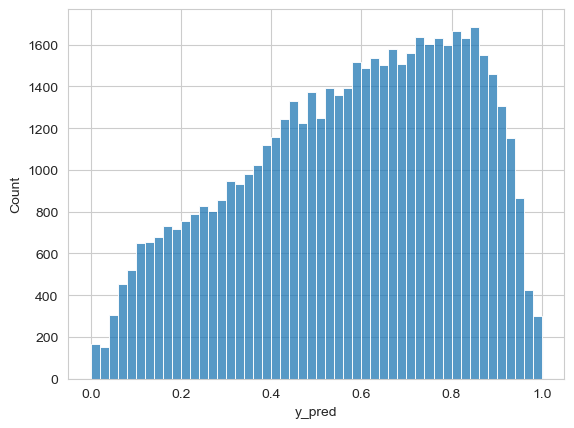

In [131]:
sns.histplot(data=X_val_, x='y_pred')

In [132]:
import os

statement = f'kaggle competitions submit -c bike-availability-prediction -f {fname} -m "V3: {model_name}"'
display('> ' + statement)
os.system(f'kaggle competitions submit -c bike-availability-prediction -f {fname} -m "V3: {model_name}"')

'> kaggle competitions submit -c bike-availability-prediction -f ./results/v3_5.csv -m "V3: 1 regression per station (more features)"'

100%|██████████| 1.30M/1.30M [00:08<00:00, 165kB/s] 


Successfully submitted to Bike Availability Prediction

0

In [27]:
X_val.day.unique()

array([ 7, 23, 31,  4,  6, 15,  8, 30, 28,  9, 25, 12,  3, 24, 21, 18, 19,
       17, 27, 20,  2,  1, 13,  5, 14, 10, 22, 16, 11, 29])